## Описание задания

Есть 4 последовательных кадра, снятых на телефон. На этих кадрах 
нейросеть предсказала положение одного и того же знака. Нужно определить 
местоположение этого знака в мировых координатах - (latitude, longitude).

## Описание данных

### Папка images

Здесь хранятся изображения в формате jpg.

### predictions.json

В файл записана информация о предиктах знака с каждого кадра. У каждого filename
есть информация о:
- **label** - класс дорожного знака
- **x_from**, **y_from**, **width**, **height** - координаты ограничивающего бокса знака на кадре

### frames_info.json

В файл записана метаинформация для каждого кадра. В нем есть:
- **timestamp** - время записи кадра. Чтобы получить время в utc формате - нужно timestamp 
поделить на 1000
- **lat**, **lon**, **alt** - координаты места съемки. lat и lon в градусах, alt в метрах
- **azimuth** - азимут в градусах
- **speed** - скорость в км/ч
- **FocalLength** - фокусное расстояние в мм
- **FocalPlaneXResolution**, **FocalPlaneYResolution** - ширина и высота сенсора камеры в мм

### gps_info.json

Использовать этот файл необязательно, в нем записаны сырые данные gps.
Из них для каждого кадра интерполяцией получали координаты.

In [11]:
import cv2
import numpy as np
import json
import os

from IPython.display import display
from PIL import Image

In [12]:
img_dir = "images"
predict_json = "predictions.json"
frames_info = "frames_info.json"

with open(predict_json, 'r') as f:
    predict = json.load(f)
    
with open(frames_info, 'r') as f:
    frames = json.load(f)
    
predict

{'1677486377074_56.639291854056_47.890889954250.jpg': {'height': 36,
  'label': '3_27',
  'width': 36,
  'x_from': 1080,
  'y_from': 540},
 '1677486378104_56.639275207806_47.890988629361.jpg': {'height': 47,
  'label': '3_27',
  'width': 48,
  'x_from': 1126,
  'y_from': 495},
 '1677486379106_56.639252454750_47.891101877000.jpg': {'height': 66,
  'label': '3_27',
  'width': 64,
  'x_from': 1245,
  'y_from': 441},
 '1677486380136_56.639229259306_47.891211690194.jpg': {'height': 116,
  'label': '3_27',
  'width': 119,
  'x_from': 1567,
  'y_from': 305}}

### Отрисуем бокс знака на изображении (для проверки)

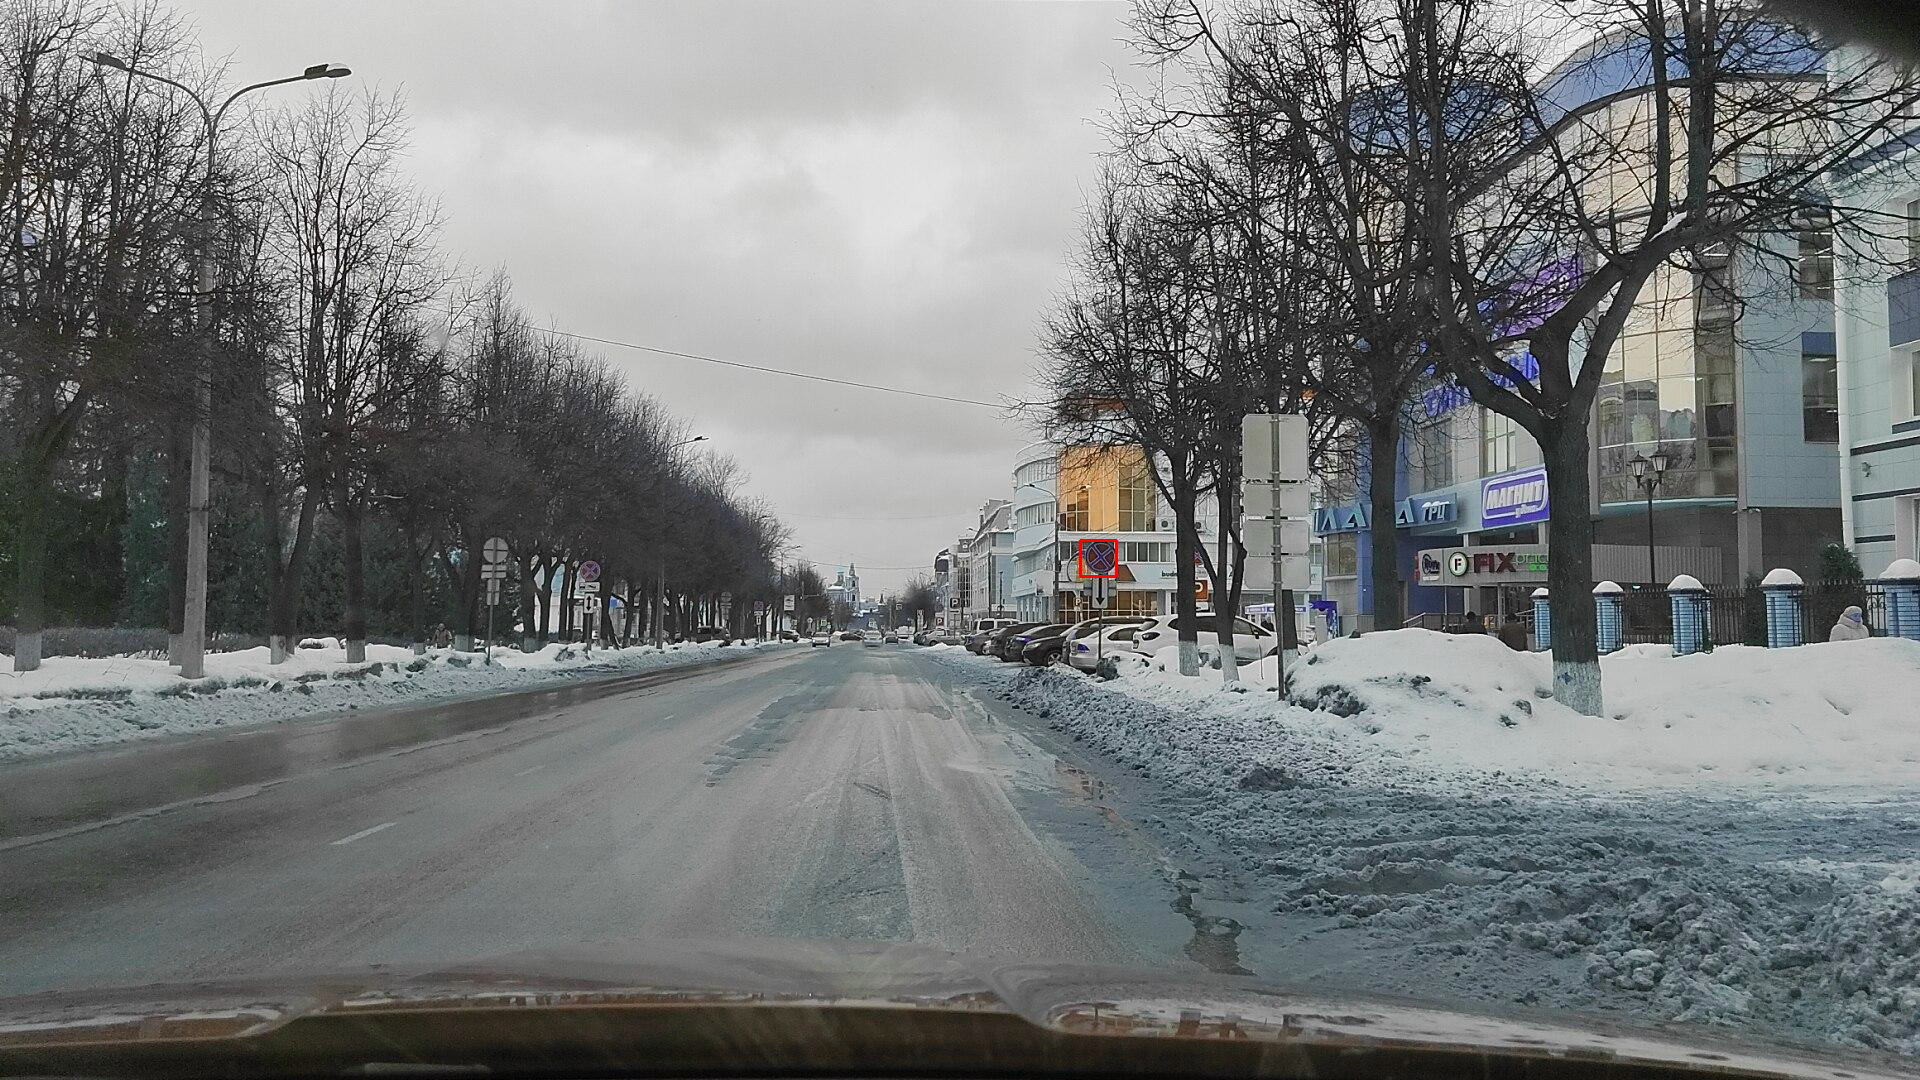

In [15]:
for k, v in predict.items():
    image = cv2.imread(os.path.join(img_dir, k))
    
    h = v["height"]
    w = v["width"]
    x = v["x_from"]
    y = v["y_from"]
    
    
    # Start coordinate (represents the top left corner of rectangle)
    start_point = (x, y)

    # Ending coordinate (represents the bottom right corner of rectangle)
    end_point = (x+w, y+h)

    color = (255, 0, 0)
    thickness = 2

    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    display(Image.fromarray(image))
    
    break

### Алгоритм нахождения координат знака

- **Азимут знака.** 
Если знак расположен точно по центру кадра, он совпадает с азимутом в GPS-точке. Если знак не по центру — это азимут в точке + угол между центром кадра и знаком. Азимут GPS-точки у нас уже есть, а угол между центром кадра и знаком мы можем посчитать, т.к. знаем, где расположена маска знака на кадре и знаем угол обзора, с которым было записано видео.

- **Расстояние до знака из GPS-точки.**
Его можем вычислить, т.к. знаем размеры маски знака, разрешение кадра и угол обзора, с которым записано видео.

(https://habr.com/ru/company/2gis/blog/457342/)